Import package

In [1]:
import tensorflow as tf
phy_dev = tf.config.list_physical_devices("GPU")
phy_dev

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [3]:
import os

import tensorflow as tf
from tensorflow import keras

print(f'Tensorflow version: {tf.version.VERSION}')

Tensorflow version: 2.8.0


In [4]:
# get stock data
df = web.DataReader('TSLA', data_source='yahoo', start='2012-01-01', end='2021-12-31')

# show data example
print(df.head(5))

             High    Low   Open  Close     Volume  Adj Close
Date                                                        
2012-01-03  5.900  5.530  5.788  5.616  4640500.0      5.616
2012-01-04  5.734  5.500  5.642  5.542  3150500.0      5.542
2012-01-05  5.586  5.370  5.552  5.424  5027500.0      5.424
2012-01-06  5.558  5.282  5.440  5.382  4931500.0      5.382
2012-01-09  5.498  5.224  5.400  5.450  4485000.0      5.450


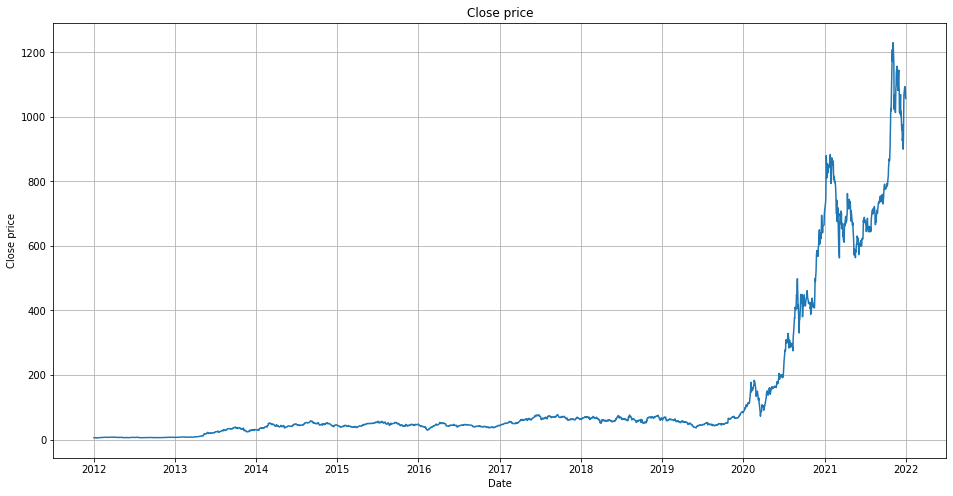

In [5]:
# visualize the closing price history
plt.figure(1, figsize=(16,8))
plt.title('Close price')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close price')
plt.grid()

In [6]:
# get only close price data
close_hist = df.filter(['Close'])

# change to numpy array
close_hist = close_hist.to_numpy()

# scale to 0 to 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_close_hist = scaler.fit_transform(close_hist)
scaled_close_hist

array([[8.63425414e-04],
       [8.03034313e-04],
       [7.06735432e-04],
       ...,
       [8.82711181e-01],
       [8.69776143e-01],
       [8.58709987e-01]])

In [7]:
train, test = train_test_split(scaled_close_hist, test_size=0.2, shuffle=False)

X_train = []
y_train = []
X_test = []
y_test = []

for idx in range(60, len(train)):
    X_train.append(train[idx-60:idx,0])
    y_train.append(train[idx])

for idx in range(60, len(test)):
    X_test.append(test[idx-60:idx,0])
    y_test.append(test[idx])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [8]:
X_train =  np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1953, 60, 1)

In [9]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
1953/1953 [==============================] - 24s 11ms/step - loss: 2.0036e-05
Epoch 2/10
1953/1953 [==============================] - 21s 11ms/step - loss: 9.5146e-06
Epoch 3/10
1953/1953 [==============================] - 24s 12ms/step - loss: 7.5910e-06
Epoch 4/10
1953/1953 [==============================] - 24s 12ms/step - loss: 4.9422e-06
Epoch 5/10
1953/1953 [==============================] - 21s 11ms/step - loss: 5.2095e-06
Epoch 6/10
1953/1953 [==============================] - 27s 14ms/step - loss: 4.9295e-06
Epoch 7/10
1953/1953 [==============================] - 26s 13ms/step - loss: 3.7578e-06
Epoch 8/10
1953/1953 [==============================] - 22s 11ms/step - loss: 4.0446e-06
Epoch 9/10
1953/1953 [==============================] - 25s 13ms/step - loss: 3.7874e-06
Epoch 10/10
1953/1953 [==============================] - 27s 14ms/step - loss: 3.5836e-06


In [12]:
model.save('saved_model/tsla_model')

INFO:tensorflow:Assets written to: saved_model/tsla_model\assets


INFO:tensorflow:Assets written to: saved_model/tsla_model\assets


In [13]:
X_test =  np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred = model.predict(X_test)
pred = scaler.inverse_transform(pred)
y_test = scaler.inverse_transform(y_test)

In [14]:
rmse = np.sqrt(np.mean(pred - y_test)**2)
rmse

83.58709192705584

In [15]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,5.900000,5.530000,5.788000,5.616000,4640500.0,5.616000
2012-01-04,5.734000,5.500000,5.642000,5.542000,3150500.0,5.542000
2012-01-05,5.586000,5.370000,5.552000,5.424000,5027500.0,5.424000
2012-01-06,5.558000,5.282000,5.440000,5.382000,4931500.0,5.382000
2012-01-09,5.498000,5.224000,5.400000,5.450000,4485000.0,5.450000
...,...,...,...,...,...,...
2021-12-27,1117.000000,1070.719971,1073.670044,1093.939941,23715300.0,1093.939941
2021-12-28,1119.000000,1078.420044,1109.489990,1088.469971,20108000.0,1088.469971
2021-12-29,1104.000000,1064.140015,1098.640015,1086.189941,18718000.0,1086.189941


In [16]:
len(train)
len(test)
pred.shape

(444, 1)

In [17]:
trian_len = len(train)
train_data = df[:trian_len]
val_data = df[trian_len+60:]
val_data['Prediction'] = pred


C:\Users\chubb\AppData\Local\Temp\ipykernel_13424\3406496055.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['Prediction'] = pred


In [18]:
val_data

,High,Low,Open,Close,Volume,Adj Close,Prediction
Date,,,,,,,
2020-03-31,108.592003,99.400002,100.250000,104.800003,88857500.0,104.800003,100.092308
2020-04-01,102.790001,95.019997,100.800003,96.311996,66766000.0,96.311996,104.167747
2020-04-02,98.851997,89.279999,96.206001,90.893997,99292000.0,90.893997,95.696281
2020-04-03,103.098000,93.678001,101.900002,96.001999,112810500.0,96.001999,90.401955
2020-04-06,104.199997,99.592003,102.239998,103.248001,74509000.0,103.248001,95.128410
...,...,...,...,...,...,...,...
2021-12-27,1117.000000,1070.719971,1073.670044,1093.939941,23715300.0,1093.939941,844.243530
2021-12-28,1119.000000,1078.420044,1109.489990,1088.469971,20108000.0,1088.469971,867.319153
2021-12-29,1104.000000,1064.140015,1098.640015,1086.189941,18718000.0,1086.189941,869.892090


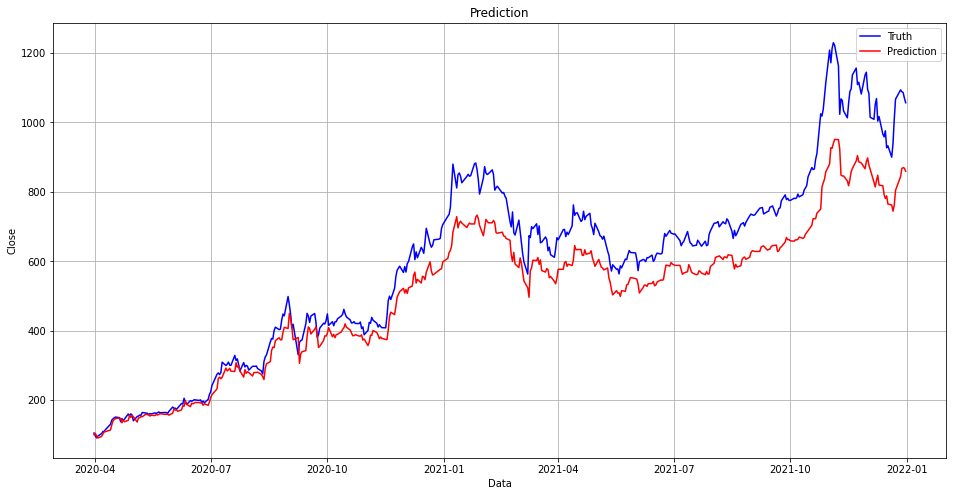

In [19]:

plt.figure(1, figsize=(16,8))
plt.title('Prediction')
plt.xlabel('Data')
plt.ylabel('Close')
plt.plot(val_data['Close'],'-b')
plt.plot(val_data['Prediction'], '-r')
plt.legend(['Truth','Prediction'])
plt.grid()